# chessy
Transfer online chess game image into encoded string
FEN \\
This notebook is to run on Google Colab.

## Import libraries

In [2]:
import cv2
from PIL import Image
from google.colab.patches import cv2_imshow
import numpy as np

## Load and Preprocess

Image loading, custom grayscale for transparent background

In [122]:
def loadImage(path, show=False, customgray=False):
    img = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    if customgray:
        nimg = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        for i in range(nimg.shape[0]):
            for j in range(nimg.shape[1]):
                if img[i][j][3] == 0:
                    nimg[i][j] = 128
        img = nimg
    else:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    if show:
        cv2_imshow(img)
        print(img.shape)
    return img

Find and crop the image to contain the chessboard only

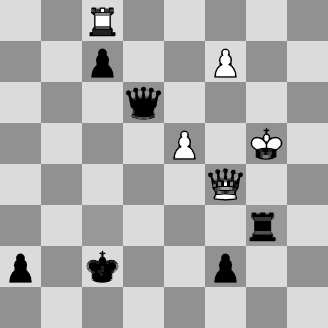

In [99]:
# find and draw chessboard corners
def cropChessboard(img, show=False):
    r = 7
    c = 7
    found, corners = cv2.findChessboardCorners(img, (r,c), None)
    if found == False:
        print("Chessboard not found.")
        return None
    # Crop image to only board
    corners = np.floor(np.squeeze(corners)).astype(int)
    sq_size = corners[1][0] - corners[0][0]
    top_left = (corners[0][0]-sq_size, corners[0][1]-sq_size)
    b_width = 8 * sq_size
    b_height = 8 * sq_size
    img = img[top_left[1]+1:top_left[1]+b_height+1, top_left[0]+1:top_left[0]+b_width+1]
    if show:
        cv2_imshow(img)
        print("Shape: ", img.shape)
        print("Square size: ", sq_size)
    return img, sq_size

Split the board into 8x8 images of squares

In [100]:
def splitBoard(img, sq_size, show=False):
    img = np.reshape(img, (img.shape[0]//sq_size, sq_size, img.shape[1]//sq_size, sq_size))
    # img = np.swapaxes(np.swapaxes(img, 1, 2), 0, 1)
    img = np.swapaxes(img, 1, 2)
    if show:
        for i in range(0, 8):
            for j in range(0, 8):
                cv2_imshow(img[i][j])
    return img


Load and process Piece sprites

In [192]:
pieces = [
    "K", "Q", "B", "N", "R", "P",
    "k", "q", "b", "n", "r", "p", " "
]

def spriteToPieces(img, show=False):
    p_size = img.shape[1] // 6
    # resize to 1D array, each p_size x p_size
    img = np.reshape(img, (2, p_size, 6, p_size))
    img = np.swapaxes(img, 1, 2)
    img = np.reshape(img, (12, p_size, p_size))
    print(img.shape)
    if show:
        for i in range(0, 12):
            print(pieces[i])
            cv2_imshow(img[i])
    return img

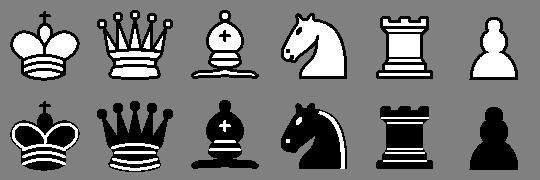

(180, 540)
(12, 90, 90)
K


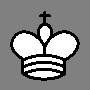

Q


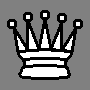

B


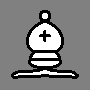

N


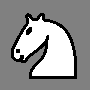

R


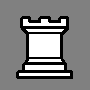

P


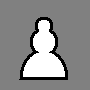

k


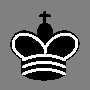

q


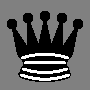

b


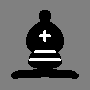

n


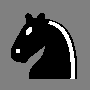

r


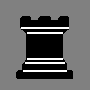

p


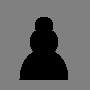

In [263]:
p_sheet = loadImage('sprite2.png', show=True, customgray=True)
p_sheet = spriteToPieces(p_sheet, show=True)

## SIFT and BF Matcher for Piece Recognition

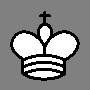

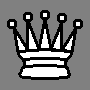

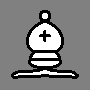

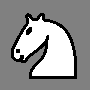

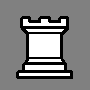

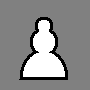

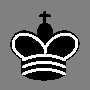

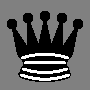

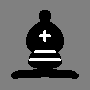

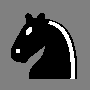

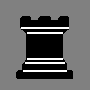

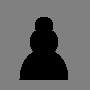

In [279]:
sift = cv2.SIFT_create()
kp = []
des = []
for i in range(0, 12):
    kp_i, des_i = sift.detectAndCompute(p_sheet[i], None)
    kp.append(kp_i)
    des.append(des_i)
    cv2_imshow(p_sheet[i])

bf = cv2.BFMatcher()
def pieceRecognizer(img):
    max = 0
    index = -1
    qk, qd = sift.detectAndCompute(img, None)
    for i in range(0, 12):
        matches = bf.knnMatch(qd, des[i], k=2)
        good = []
        for m, n in matches:
            if m.distance < 0.8 * n.distance:
                good.append([m])
        if len(good) > max:
            max = len(good)
            index = i

    return pieces[index]

## Run examples

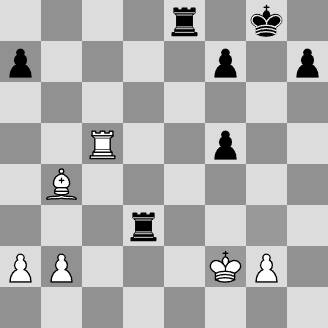

4r1k1/p4p1p/8/2R2p2/1B6/3r4/RP3KR1/8


In [286]:
board_img = loadImage('l3.png')
board_img, sq_size = cropChessboard(board_img)
cv2_imshow(board_img)
squares =splitBoard(board_img,sq_size)

# cv2_imshow(squares[1][5])
# pieceRecognizer(squares[1][5])

FEN = ""
for i in range(0, 8):
    d = 0
    for j in range(0, 8):
        # print(pieceRecognizer(squares[i][j]), end=" ")
        p = pieceRecognizer(squares[i][j])
        if p == " ":
            d+=1
        else:
            if d > 0:
                FEN += str(d)
                d = 0
            FEN += p
    if d > 0:
        FEN += str(d)
    if i < 7:
        FEN += "/"

print(FEN)